In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

## Gong problem:

Object of mass m, subject to force F(t) and friction $\alpha$v(t), moving from A to B in a given time with the least amount of work.

That is:

Minimize $\int_{t_0}^{t_f} \dot{q}(t)F(t)dt$

subject to:

$\ddot{q}(t) = -\dot{q}(t) + F(t)$

$(q_0, \dot{q}_0, t_0) = (0,1,0)$

$(q_f, \dot{q}_f, t_f) = (1,1,1)$

#### Theorical Solution:

$q(t) = t$

$\dot{q}(t) = 1$

$F(t) = 1$

In [2]:
def g_q(q, qdot, u, params=None):
    return u-qdot

In [3]:
from chords.opti import Opti_Problem
from chords.piecewise import expand_G
import time
from functools import lru_cache
import casadi as cas

In [4]:
params = []

In [5]:
f_x_cas = expand_G(g_q, 'casadi')

In [6]:
g_q(1,-1,3)

4

In [7]:
f_x_cas(np.array([1,-1]), 3, [])

DM([-1, 4])

In [8]:
_opti = Opti_Problem(
        LM=f_x_cas,
        params = params,
        scheme = 'LG',
        ini_guess= 'lin',
        t_end = 1,
        verbose=True,
        silent=False,
    )

Dynamics detected: Function


In [9]:
_opti.dynamic_setup('f_x', 1, 1)

In [10]:
_opti.opti_setup(20)
_opti.apply_scheme()
opti = _opti.opti

V = _opti.opti_arrs['v_like_u']
U = _opti.opti_arrs['u']
X_s = _opti.opti_points['x_s']
X_e = _opti.opti_points['x_e']

In [11]:
_opti.initial_guess([0], [1])

In [12]:
U.shape

(20, 1)

In [13]:
V.shape

(20, 1)

def casadi_prod(*arrs):
    arr_lists = []
    for arr in arrs:
        arr_lists.append(cas.vertsplit(arr))
    prod = []
    for ii in range(len(arr_lists[0])):
        pp = 1
        for jj in range(len(arr_lists)):
            print(ii,jj)
            pp = pp*arr_lists[jj][ii]
        prod.append(pp)
    return cas.vertcat(*prod)

In [14]:
from chords.pseudospectral import v_coef

v_coef(N+1, 0, scheme, 16, 2)

In [15]:
@lru_cache(maxsize=None)
def casadi_gong(scheme, N, ini_guess='lin', solve_repetitions = 1, t_end = 1, verbose = False, silent = True):
    _opti = Opti_Problem(
        LM=f_x_cas,
        params = params,
        scheme = scheme,
        ini_guess= ini_guess,
        t_end = t_end,
        verbose=verbose,
        silent=silent,
    )
    _opti.dynamic_setup('f_x', 1, 1)
    _opti.opti_setup(N)
    if ini_guess == 'lin':
        _opti.initial_guess([0], [1])
    
    _opti.apply_scheme()
    opti = _opti.opti
    
    V = _opti.opti_arrs['v_like_u']
    U = _opti.opti_arrs['u']
    X_s = _opti.opti_points['x_s']
    X_e = _opti.opti_points['x_e']
    if 'parab' in scheme:
        U_c = _opti.opti_arrs['u_c']
        V_c = _opti.opti_arrs['v_c']
    cost_arr = V*U
    if 'parab' in scheme:
        cost_arr_c = V_c * U_c
        _opti.quad_cost(cost_arr, cost_arr_c)
    else:
        _opti.quad_cost(cost_arr)
        
   # Initial and final conditions
    opti.subject_to(X_s.T == [0, 1])
    opti.subject_to(X_e.T == [1, 1])
    
    # Appliying restrictions and action boundaries
    u_max = 2
    u_min = 0
    for ii in range(N):
        if 'parab' in scheme:
            opti.subject_to(opti.bounded(u_min, U_c[ii,:] ,u_max))
        
        opti.subject_to(opti.bounded(u_min,U[ii,:],u_max))
    opti.subject_to(opti.bounded(u_min,U[-1, :],u_max))
    
    _opti.chrono_solve(solve_repetitions=solve_repetitions,)
    return _opti.results

In [16]:
scheme = 'LGL'
N = 60


_res = casadi_gong(
    scheme = scheme,
    N = N,
    ini_guess='lin',
    solve_repetitions = 1,
    t_end = 1,
    verbose = False,
    silent = True
)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



(-0.1, 1.1)

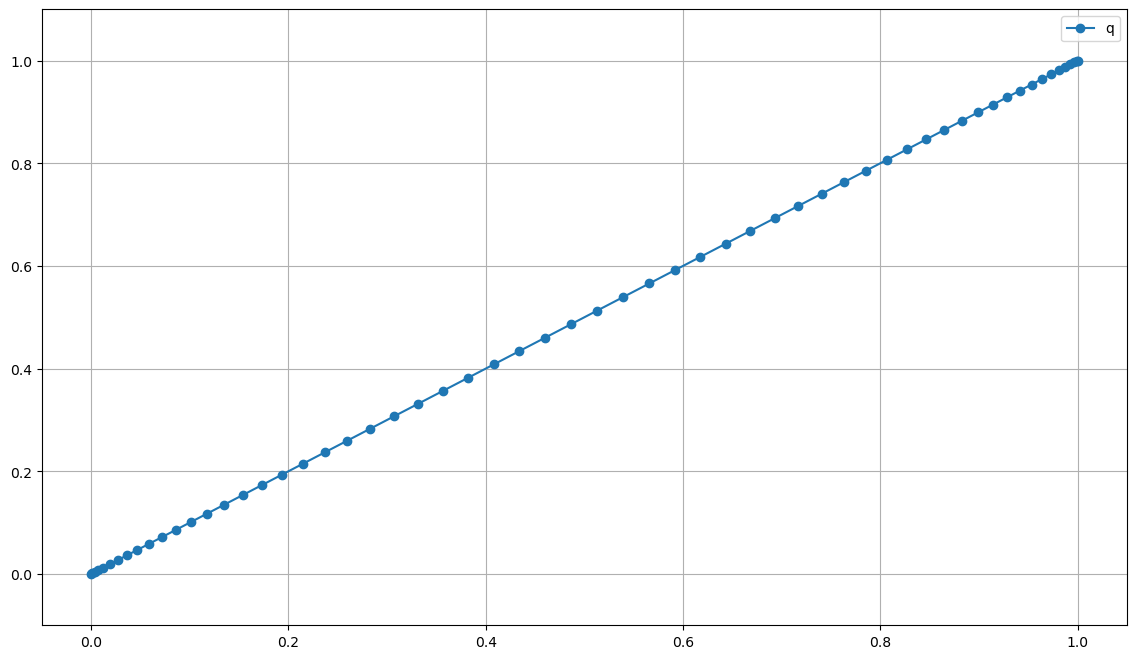

In [17]:
plt.figure(figsize=[14,8])
labels= ['q']
plt.plot(_res['t'],_res['q'][:], marker = 'o', label = 'q')
if 'parab' in scheme:
    plt.plot(_res['t_c'],_res['q_c'][:], 'o', label = 'q' + '_c')
plt.grid()
plt.legend()
plt.ylim(-0.1, 1.1)

(-0.1, 1.1)

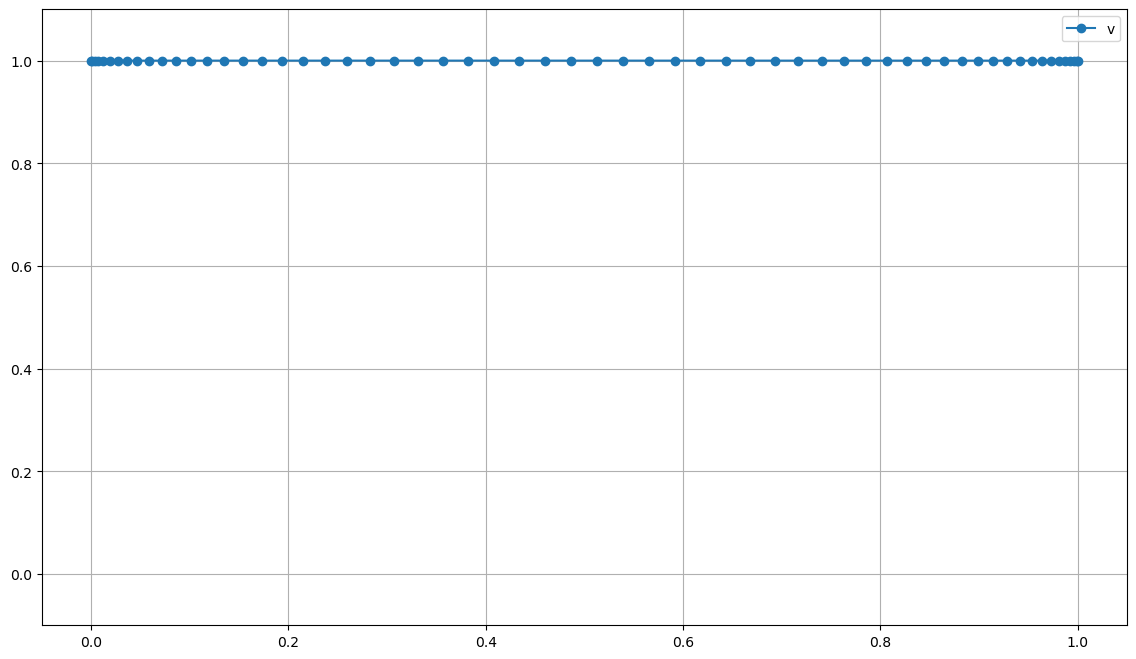

In [18]:
plt.figure(figsize=[14,8])
labels= ['v']
plt.plot(_res['t'],_res['v'][:], marker = 'o', label = 'v')
if 'parab' in scheme:
    plt.plot(_res['t_c'],_res['v_c'][:], 'o', label = 'v' + '_c')
plt.grid()
plt.legend()
plt.ylim(-0.1, 1.1)

(-0.1, 2.1)

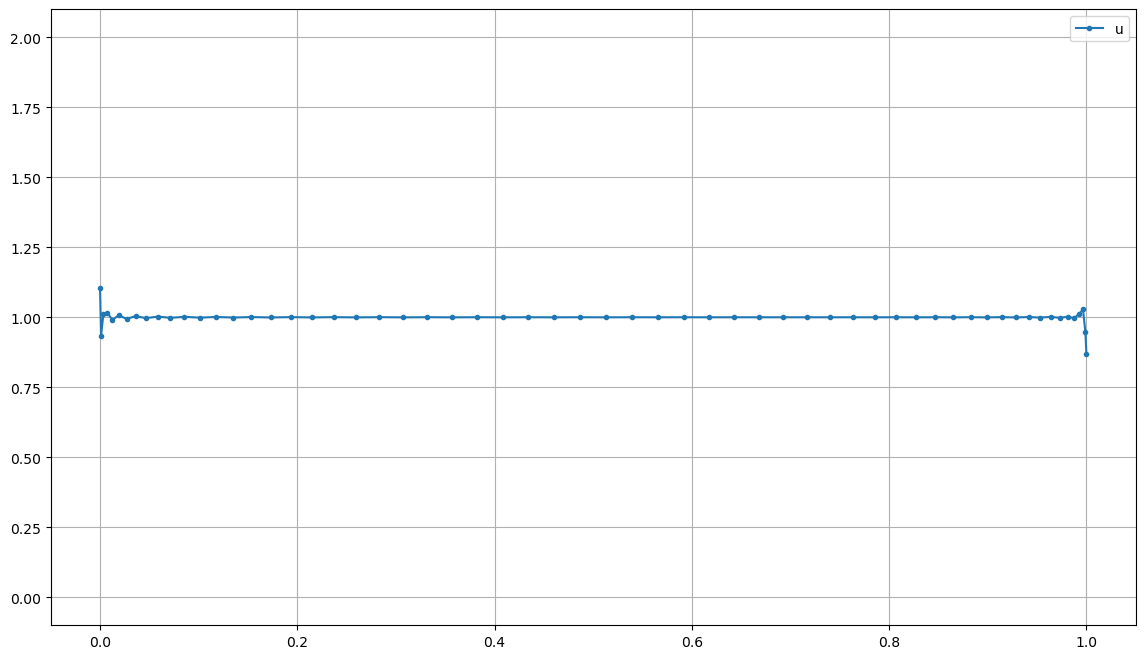

In [19]:
plt.figure(figsize=[14,8])
labels= ['u']
plt.plot(_res['t_col'],_res['u'][:], marker = '.', label = 'u')
if 'parab' in scheme:
    plt.plot(_res['t_c'],_res['u_c'][:], '.', label = 'u' + '_c')
plt.grid()
plt.legend()
plt.ylim(-0.1, 2.1)